# Patient Biopsies

## Goals

1. Which subpopulation of each biopsy is most plastic? 
    - Expectation: We will be able to quantify plasticity of the cancer cells and then compare within each sample to determine which cluster is most plastic.
    - Methods: 
        - **Should we batch correct?**
        - RNA velocity and dimensionality reduction (**what DR do we want to use?**)
        - Plasticity quantification using two metrics (**what do the end states look like? Are there clusters/ what is the multiplicity of eigenvalue 1?**)
    - Possible pitfalls: Not much range in plasticity within a data set. Several regions of the data set have high plasticity. We need to decide what dimensionality reduction to use- PCA space? We proposed working on the UMAP, which will not work well if there are several subpopulations that are discontinuous.
2. Is it consistent across treatments? 
    - We expect that the post-treatment tumors will have subpopulations with higher plasticity. We will want to compare what subpopulations there are and the plasticity of each. 
    - Methods:
        - Identify cancer subtypes to match across samples/treatment.
        - Compare plasticity of each subtype directly.
        - Consider size of each sample and each subpopulation-- **does number of cells confound plasticity calculations?**
    - Pitfalls: we will need to match subpopulations across samples-- for example, if there are A cells before and after treatment, do those change significantly in phenotype or plasticity?
3. How does the presence and proportion of immune cells affect plasticity of cancer cells?

In [3]:
import sys
sys.path.insert(1, "/Users/smgroves/Dropbox (VU Basic Sciences)/pycharm_workspace/mazebox/")
import mazebox as mb
import scvelo as scv
import scanpy as sc
import os.path as op
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read in data and preprocess.
1. Use cell_ids_biopsies.csv to subset data and identify cancer cells versus immune cells.
2. Filter genes, normalize, and log-transform.
3. Visualize using UMAP and/or tSNE.
4. Cluster data using leiden or louvain.
4. Find marker genes for each cluster, as well as expression of SCLC markers.

In [4]:
indir = "../data/patient-biopsies/"
outdir = './out/processed-data/patient-biopsies'

if not os.path.exists(outdir):
    os.makedirs(outdir)
    
samples = [f for f in os.listdir(indir) if f.endswith('.loom')]
print(samples)
[a1,a2,a3,a4,a5,a6,a7,a8,a9] = [mb.pp.read_loom(sample.split('.')[0], indir) for sample in samples] #split to remove .loom from file name


['SC134_142A_FYKY4.loom', 'SC123_138A_57U8G.loom', 'SC134_145A_43LG5.loom', 'SC123_135A_5K9UN.loom', 'SC140_145B_GLO1Q.loom', 'SC123_140A_6SIM9.loom', 'SC140_142B_DB04B.loom', 'SC134_135B_HLS1M.loom', 'SC134_146A_D4F1K.loom']


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'Chromosome' 

## Filter and concatenate

In [5]:
tfs = ['SP100', 'FOSL1', 'HES1', 'NFKBIZ', 'RELB', 'EPAS1', 'BCL3', 'REST', 'SP110', 'NFKB2', 'TEAD2', 'HMG20B', 'SIX5',
       'RARG', 'TEAD4', 'ZNF217', 'SP140L', 'SOX18', 'HOXC13', 'STAT6', 'ETV4', 'KLF2', 'MITF', 'NR0B2', 'ASCL1', 'ZBTB7C', 'ELF3',
       'RORC', 'FOXA2', 'ETS2','TOX3', 'XBP1', 'ST18', 'FOXA1', 'OVOL2', 'ZNF664', 'TBX10', 'PROX1', 'ETV6', 'CEBPD', 'TFCP2L1', 'FOXJ3',
       'ZNF407', 'ZNF511','ZNF396', 'RBPJ', 'ZSCAN31', 'HOXB5', 'ZNF3', 'TSHZ2', 'ZBTB16', 'ZNF10', 'FLI1', 'GATA4', 'NR0B1', 'NHLH1',
       'NEUROD6', 'ZNF581', 'TCF15', 'LYAR', 'ISL2', 'OLIG2', 'NEUROD1', 'INSM1', 'PAX5', 'SP6', 'MYT1', 'HES6', 'ZNF24', 'ISL1', 'ZNF397',
       'SOX11', 'ZNF253', 'SMAD4', 'RBP1', 'ONECUT2', 'ZNF711', 'DLX5', 'GRIP1', 'ZNF157', 'ZNF713', 'ZNF136', 'FOXN4', 'PATZ1', 'ZNF491',
       'ZBTB21', 'KLF12', 'ZNF501', 'ZNF785', 'CXXC1', 'ZNF324', 'ZNF764', 'ZBTB18', 'KAT8', 'ZNF334', 'POU4F1', 'ZNF250', 'ZNF132',
       'SALL2', 'DLX6', 'MBD1','SOX1', 'ZFP3', 'ZNF543', 'POU2F1', 'NONO', 'SMAD9', 'ZKSCAN2', 'TCF12', 'VEZF1', 'TOX', 'BHLHE22', 'MTA1',
       'TCF3', 'SCRT2', 'RFX7','NHLH2', 'SCRT1', 'RCOR2', 'PURG', 'TBPL1', 'TCF4', 'EBF1', 'ZNF749', 'NEUROD2', 'ZNF423', 'BACH2', 'GLI1',
       'ZFP64','NKX2-1', 'MYC', 'YAP1', 'POU2F3', 'MYCL', 'MYCN', 'ASCL2', 'AVIL', 'CHAT', 'GFI1B',
      'CHGA','EPCAM']


Dropkick is a tool to get rid of empty and low-quality droplets based on ambient reads. It should be applied to each sample separately, so we will apply first and then concantenate the data into one AnnData object.

In [6]:
#['SC134_142A_FYKY4.loom', 'SC123_138A_57U8G.loom', 'SC134_145A_43LG5.loom', 'SC123_135A_5K9UN.loom', 'SC140_145B_GLO1Q.loom', 
#'SC123_140A_6SIM9.loom', 'SC140_142B_DB04B.loom', 'SC134_135B_HLS1M.loom', 'SC134_146A_D4F1K.loom']
batch_categories = ['142A','138A','145A','135A','145B','140A','142B','135B','146A']
batch_key = 'tumor'

adata = a1.concatenate([a2,a3,a4,a5,a6,a7,a8,a9], batch_key=batch_key, batch_categories=batch_categories)


In [7]:
adata = mb.pp.scanpy_recipe(adata, retain_genes=tfs,)

Filtered out 7033 genes that are detected in less than 3 cells (spliced).
Normalized count data: X, spliced, unspliced.
Logarithmized X.


## Filter cells by cancer/immune populations and add labels
ids contains barcodes, tumors, and cell type.

In [15]:
ids = pd.read_csv('../data/patient-biopsies/cell_ids_biopsies.csv')
ids.columns = ['id','type']

,id,type
0,135A.AAACCCAAGTCATGCT,Immune_cells.NK_cells
1,135A.AAACCCACAAAGGCTG,Cancer_cells.Epithelial_cells
2,135A.AAACCCACAGCGGATA,Cancer_cells.Epithelial_cells
3,135A.AAACCCAGTGTCCGGT,Cancer_cells.Epithelial_cells
4,135A.AAACCCATCACCTCTG,Cancer_cells.Epithelial_cells


Separate tumor and cell ID, and population type (cancer/immune) and cell type.

In [17]:
cellids = ids.id.str.split('.', expand = True)
cellids.columns = ['tumor','cellID']
cellids['poptype'] = ids.type.str.split('.', expand = True)[0]
cellids['celltype'] = ids.type.str.split('.',expand = True)[1]
cellids.head()

,tumor,cellID,poptype,celltype
0,135A,AAACCCAAGTCATGCT,Immune_cells,NK_cells
1,135A,AAACCCACAAAGGCTG,Cancer_cells,Epithelial_cells
2,135A,AAACCCACAGCGGATA,Cancer_cells,Epithelial_cells
3,135A,AAACCCAGTGTCCGGT,Cancer_cells,Epithelial_cells
4,135A,AAACCCATCACCTCTG,Cancer_cells,Epithelial_cells


In [32]:
adata.obs['index'] = adata.obs.index

adata.obs['brcd'] = adata.obs['index'].str.split(':',expand = True)[1].str.split('x', expand = True)[0]

In [58]:
p = pd.merge(left = adata.obs, left_on = ['brcd','tumor'],
        right = cellids, right_on=['cellID','tumor']).drop('cellID',axis = 1, )
p.index = p['index']


In [67]:
adata.obs['poptype'] = p.poptype
adata.obs['celltype'] = p.celltype

In [70]:
adata.obs.head()

,tumor,n_genes,initial_size_spliced,initial_size_unspliced,initial_size,n_counts,index,brcd,poptype,celltype
CellID,,,,,,,,,,
SC134_142A_FYKY4:AAAGGATGTTGCTTGAx-142A,142A,952,2144,1236,2144.0,3275.999756,SC134_142A_FYKY4:AAAGGATGTTGCTTGAx-142A,AAAGGATGTTGCTTGA,Immune_cells,B_cells
SC134_142A_FYKY4:AAAGAACTCGTACCTCx-142A,142A,755,2102,850,2102.0,3276.000488,SC134_142A_FYKY4:AAAGAACTCGTACCTCx-142A,AAAGAACTCGTACCTC,Immune_cells,T_cells
SC134_142A_FYKY4:AAAGGTAGTCTGTCCTx-142A,142A,997,2274,2028,2274.0,3276.000000,SC134_142A_FYKY4:AAAGGTAGTCTGTCCTx-142A,AAAGGTAGTCTGTCCT,Immune_cells,B_cells
SC134_142A_FYKY4:AAAGAACTCTTCCCAGx-142A,142A,1568,3461,3224,3461.0,3275.999756,SC134_142A_FYKY4:AAAGAACTCTTCCCAGx-142A,AAAGAACTCTTCCCAG,Immune_cells,T_cells
SC134_142A_FYKY4:AAAGGATAGGTCGACAx-142A,142A,1424,3192,2420,3192.0,3276.000000,SC134_142A_FYKY4:AAAGGATAGGTCGACAx-142A,AAAGGATAGGTCGACA,Immune_cells,T_cells


## Cell Cycle Regression

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


... storing 'brcd' as categorical
... storing 'poptype' as categorical
... storing 'celltype' as categorical
... storing 'phase' as categorical


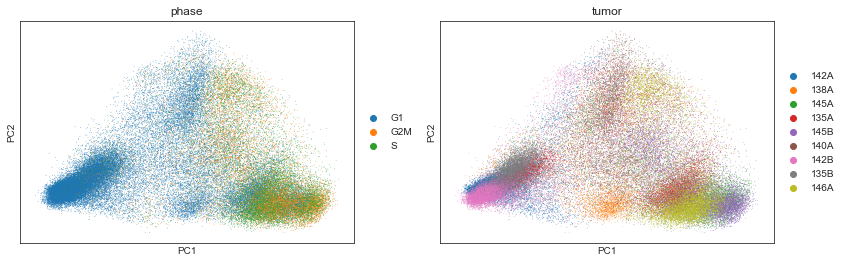

In [71]:
# sc.pp.scale(adata)
scv.tl.score_genes_cell_cycle(adata)
sc.tl.pca(adata)
sc.pl.pca_scatter(adata, color=['phase','tumor'])

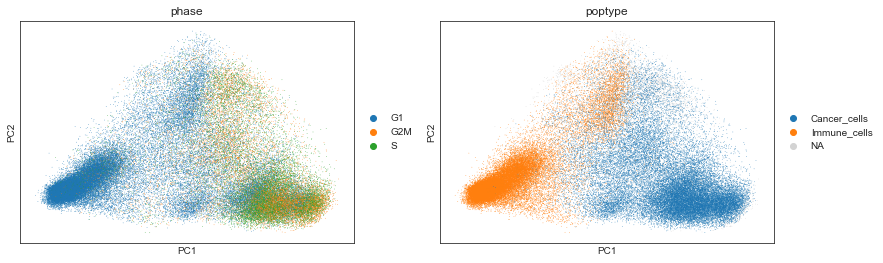

In [83]:
sc.pl.pca_scatter(adata, color=['phase','poptype'])

Interestingly, it seems that virtually all immune cells are "G1," while cancer cells are mixed. Therefore, regressing out cell cycle might get rid of some differences between the two populations, so I will leave the data as is.

In [23]:
# sc.pp.regress_out(adata, ['S_score', 'G2M_score'])


# Dimensionality Reduction and RNA Velocity

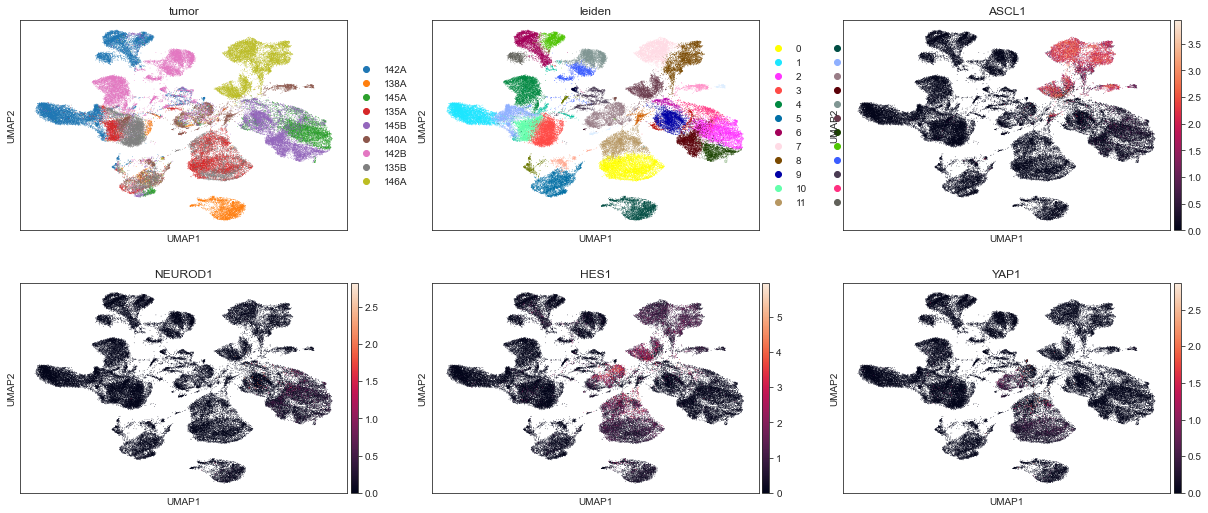

In [72]:
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata, random_state = 1)
sc.pl.umap(adata, color = ['tumor','leiden','ASCL1','NEUROD1','HES1','YAP1'], ncols = 3)


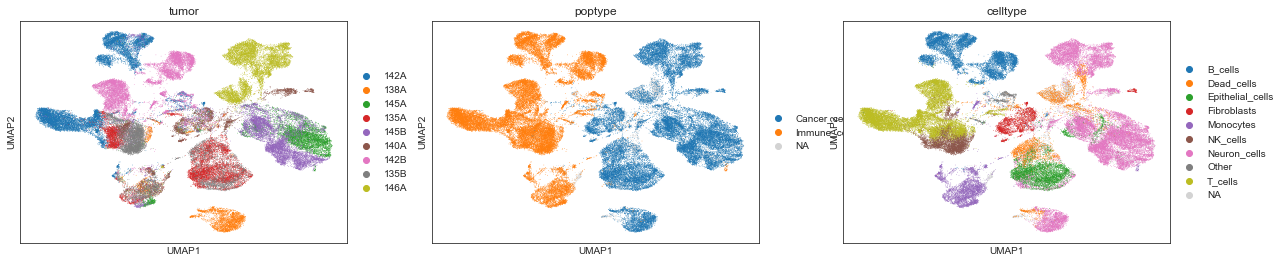

In [75]:
sc.pl.umap(adata, color = ['tumor','poptype','celltype'], ncols = 3)


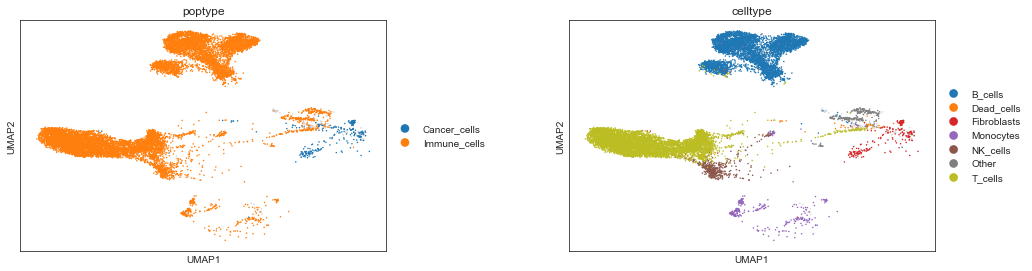

In [82]:
sc.pl.scatter(adata[adata.obs.tumor=="142A"], color = ['poptype','celltype'], basis = 'umap')


In [74]:
adata.write_h5ad(outdir+'/adata01.h5ad')

In [78]:
set(ids.type)

{'Cancer_cells.Dead_cells',
 'Cancer_cells.Epithelial_cells',
 'Cancer_cells.Fibroblasts',
 'Cancer_cells.Neuron_cells',
 'Immune_cells.B_cells',
 'Immune_cells.Monocytes',
 'Immune_cells.NK_cells',
 'Immune_cells.Other',
 'Immune_cells.T_cells'}

In [86]:
pd.crosstab(adata.obs.poptype, adata.obs.tumor, normalize="columns")

tumor,142A,138A,145A,135A,145B,140A,142B,135B,146A
poptype,,,,,,,,,
Cancer_cells,0.021838,0.799128,0.877436,0.666625,0.880597,0.503235,0.034339,0.332797,0.989224
Immune_cells,0.978162,0.200872,0.122564,0.333375,0.119403,0.496765,0.965661,0.667203,0.010776


**Conclusions**

All tumors have some cancer and immune cells, although the proportions vary greatly between the tumors. For example, 142A is almost entirely immune cells, while 146A is almost entirely cancer cells. For the most part it seems tumors before and after treatment have similar proportions, *except* 135, which originally is two thirds cancer cells and after treatment is two thirds immune cells. This may be a very interesting case for evaluating changing immune populations. 

In [89]:
pd.crosstab(adata[adata.obs.poptype == 'Immune_cells'].obs.celltype, 
            adata[adata.obs.poptype == 'Immune_cells'].obs.tumor, normalize="columns").style.background_gradient('viridis')

tumor,142A,138A,145A,135A,145B,140A,142B,135B,146A
celltype,,,,,,,,,
B_cells,0.393635,0.029457,0.014455,0.008286,0.135000,0.020385,0.452895,0.001447,0.071429
Monocytes,0.025493,0.519380,0.651774,0.219209,0.291000,0.483012,0.032103,0.184998,0.785714
NK_cells,0.038556,0.189147,0.149803,0.302825,0.263000,0.191959,0.049018,0.482875,0.057143
Other,0.019238,0.062016,0.007884,0.003013,0.077000,0.013024,0.017903,0.002171,0.028571
T_cells,0.523078,0.200000,0.176084,0.466667,0.234000,0.291619,0.448080,0.328509,0.057143


When we look at the subpopulations of immune cells in each tumor, we notice a few things. 
1. 142: B cells proportion increased (\~6%); T cells decreased (~8%). Otherwise very similar
2. 145: Very different before and after. B cells increased (\~11%), monocytes decreased (~40%), NK increased, and T cells increased.
3. 135: Monocytes decreased, NK increased (\~18%), T cells decreased (~14%).


In [108]:
before = []
for i,r in adata.obs.iterrows():
    if (i[-1]) == 'A': before.append('Before')
    else: before.append('After')
    

In [109]:
adata.obs["before"] = before

In [129]:
pd.crosstab(adata[adata.obs.poptype == 'Immune_cells'].obs.celltype, 
            adata[adata.obs.poptype == 'Immune_cells'].obs.before, normalize="columns").style.background_gradient('viridis')

before,After,Before
celltype,,
B_cells,0.287580,0.273370
Monocytes,0.099509,0.142649
NK_cells,0.200982,0.100928
Other,0.017441,0.017379
T_cells,0.394488,0.465674


<AxesSubplot:xlabel='celltype'>

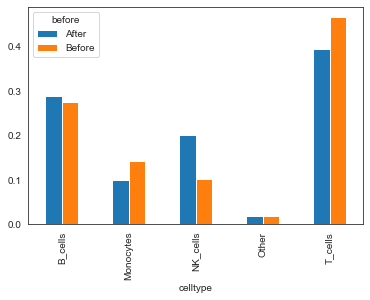

In [127]:
pd.crosstab(adata[adata.obs.poptype == 'Immune_cells'].obs.celltype, 
            adata[adata.obs.poptype == 'Immune_cells'].obs.before, normalize = 'columns').plot(kind = 'bar')

<AxesSubplot:xlabel='tumor'>

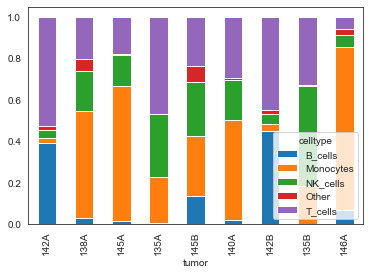

In [124]:
pd.crosstab(adata[adata.obs.poptype == 'Immune_cells'].obs.tumor, 
            adata[adata.obs.poptype == 'Immune_cells'].obs.celltype, normalize='index').plot(kind = 'bar', stacked = True)

Overall, there is a slight increase in B and NK cells after treatment, and a slight decrease in monocytes and T cells.

## Calculating Velocity

In [31]:
adata = sc.read_h5ad(outdir+'/adata01.h5ad')

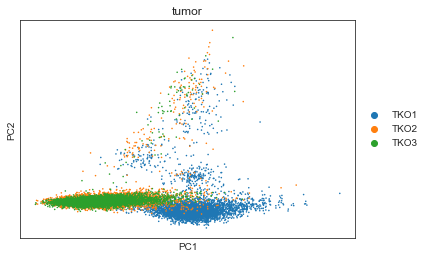

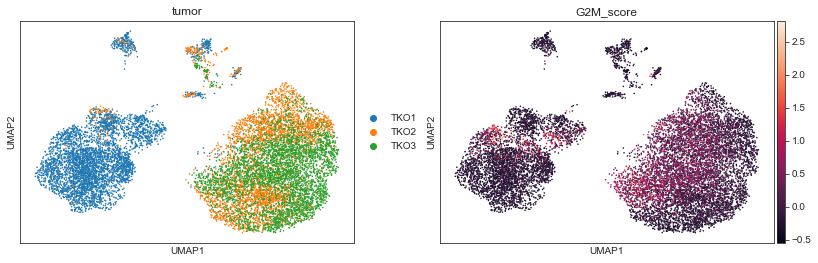

In [11]:
sc.pp.neighbors(adata, random_state=1) #recalculating after subsetting data and cell cycle correction)
sc.tl.pca(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata, random_state=1)
sc.pl.pca(adata, color = 'tumor')
sc.pl.umap(adata, color = ['tumor','G2M_score'])


## RNA velocity calculation and plasticity quantification.
CDX models from the same patient before and after treatment should be combined so they are comparable (i.e. in the same "space"). However, RNA velocity should be calculated independently for each sample.